## Mortality Predictor using MIMIC-III Database

This is a project that aims to develop a set of neural network models that predict whether the patient will survive in the intensive care unit (ICU) given its medical data recorded within first 24 hours upon admission.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0

Here we rely on the Medical Information Mart for Intensive Care (MIMIC-III) database. In order to access the MIMIC-III database, we completed the CITI “Data or Specimens Only Research” course at CITI Program. Once access was granted we directly downloaded the databases (26 csv files) and loaded it into the PostgreSQL database management system on a local machine.

In [3]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

## Data Exploration and Preprocessing

In order to access the data we use SQL queries to load specific tables that contain required information. For example, a query below requests 'admissions' table that contains, among other things, the demographics data and mortality outcome (i.e., hospital_expire_flag).

In [4]:
# Load in the query from file
query='SELECT * FROM admissions'
ad = pd.read_sql_query(query, connect)

In [5]:
ad.shape

(58976, 19)

In [6]:
ad.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


Query below requests 'APSIII' table that contains mortality probability (apsiii_prob) calculated using Acute Physiological Score (APS) rule along with various intermediate scores. We will use these APS probabilities as a benchmark to analyze performance of our models.

In [7]:
# Load in the query from file
query='SELECT * FROM APSIII'
aps = pd.read_sql_query(query, connect)

In [8]:
aps.shape

(61532, 21)

In [9]:
aps.head()

,subject_id,hadm_id,icustay_id,apsiii,apsiii_prob,hr_score,meanbp_score,temp_score,resprate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score
0,55973,152234,200001,63,0.188678,7.0,7.0,0.0,6.0,0.0,3.0,5.0,7.0,15.0,12.0,0.0,NaN,0.0,0.0,1.0,0.0
1,27513,163557,200003,48,0.102705,7.0,10.0,0.0,9.0,0.0,3.0,5.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,1.0,0.0
2,10950,189514,200006,23,0.033927,0.0,7.0,0.0,6.0,NaN,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,3.0,NaN,0.0
3,20707,129310,200007,33,0.053332,1.0,15.0,0.0,6.0,NaN,3.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,3.0,NaN,0.0
4,29904,129607,200009,26,0.038894,1.0,7.0,8.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,0.0,3.0,0.0


Below is the content of a custom SQL query that extracts various features from the various sources in MIMIC database. Majority of the features are computed as minimum, maximum and mean values of various vital and blood measurements obtained within the first 24 hours upon admission. Majority of these features will be used in the model training.

In [10]:
!pygmentize /Users/maxim/Documents/ml_nanodegree/capstone/mortality_predictor_mimic/queries/apsiii_raw.sql

with pa as
(
  select bg.icustay_id, bg.charttime
  , PO2 as PaO2
  , ROW_NUMBER() over (partition by bg.ICUSTAY_ID ORDER BY bg.PO2 DESC) as rn
  from bloodgasfirstdayarterial bg
  left join ventdurations vd
    on bg.icustay_id = vd.icustay_id
    and bg.charttime >= vd.starttime
    and bg.charttime <= vd.endtime
  WHERE vd.icustay_id is null -- is *not* ventilated
  -- and fio2 < 50, or if no fio2, assume room air
  AND coalesce(FIO2, fio2_chartevents, 21) < 50
  AND bg.PO2 IS NOT NULL
)
, aa as
(
  -- join blood gas to ventilation durations to determine if patient was vent
  -- also join to cpap table for the same purpose
  select bg.icustay_id, bg.charttime
  , bg.AADO2
  , ROW_NUMBER() over (partition by bg.ICUSTAY_ID ORDER BY bg.AADO2 DESC) as rn
  -- row number indicating the highest AaDO2
  from bloodgasfirstdayarterial bg
  INNER JOIN ventdurations vd
    on bg.icustay_id = vd.icustay_id
    and bg.charttime >= vd.starttime
    and bg.charttime <= vd.endtime
  WHERE vd.icusta

In [11]:
f = os.path.join('/Users/maxim/Documents/ml_nanodegree/capstone/mortality_predictor_mimic/queries/apsiii_raw.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
aps_raw = pd.read_sql_query(query, connect)

In [12]:
aps_raw.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,albumin_min,albumin_max,bilirubin_min,bilirubin_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,pao2,aado2
0,9514,127229,200014,58.0,71.843750,91.0,52.0,86.268525,171.000000,34.500000,35.856444,37.000000,9.0,14.378378,33.0,29.8,36.3,14.3,14.7,0.6,0.6,24.0,24.0,142.0,144.0,2.2,2.8,0.3,0.3,101.0,114.0,664.0,4.0,4.0,6.0,95.0,NaN
1,76603,179633,200024,101.0,110.571429,123.0,66.0,81.000000,100.000000,34.000000,34.300000,34.600000,18.0,20.166667,21.0,26.0,33.6,12.4,12.4,2.2,2.2,50.0,50.0,145.0,145.0,NaN,NaN,NaN,NaN,50.0,81.0,NaN,1.0,0.0,1.0,NaN,NaN
2,25225,147080,200055,72.0,86.875000,101.0,53.0,67.714286,85.000000,35.666667,36.064815,36.277778,12.0,17.833333,30.0,34.5,36.3,5.7,6.3,7.4,8.9,29.0,40.0,137.0,140.0,3.5,3.5,0.3,0.3,85.0,116.0,NaN,3.0,5.0,6.0,80.0,NaN
3,17145,105119,200068,67.0,83.625000,112.0,56.0,70.623201,84.666702,34.722222,36.904763,38.833334,20.0,22.666667,24.0,27.5,30.0,14.2,14.2,3.2,3.7,58.0,65.0,134.0,136.0,2.3,2.3,0.3,0.3,105.0,187.0,1280.0,4.0,5.0,4.0,86.0,NaN
4,52619,175374,200099,68.0,82.656250,93.0,50.0,71.500000,102.000000,36.000000,36.166667,36.444444,9.0,13.875000,22.0,28.8,34.9,8.9,9.2,1.1,1.2,20.0,20.0,138.0,140.0,NaN,NaN,NaN,NaN,84.0,258.0,955.0,3.0,5.0,6.0,88.0,NaN


In [35]:
aps_raw.describe()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,albumin_min,albumin_max,bilirubin_min,bilirubin_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,pao2,aado2
count,61532.000000,61532.000000,61532.000000,59048.000000,59048.000000,59048.000000,52288.000000,52288.000000,52288.000000,51382.000000,51382.000000,51382.000000,52229.000000,52229.000000,52229.000000,59540.000000,59540.000000,59170.000000,59170.000000,52900.000000,52900.000000,52890.000000,52890.000000,54804.000000,54804.00000,19325.000000,19325.000000,26106.000000,26106.00000,54452.000000,54452.000000,53201.000000,51988.000000,51795.000000,51734.000000,26753.000000,2887.000000
mean,33888.605912,149954.470649,249962.710248,77.499570,91.704638,109.723335,58.310360,77.906124,104.690279,36.095355,36.817087,37.470816,12.364435,18.853713,27.275403,32.036125,37.209335,11.012047,13.884411,1.325493,1.575013,24.039024,28.386141,136.661065,140.08174,3.115281,3.200476,2.043297,2.33418,103.395390,206.314501,1820.675878,3.123836,3.189439,5.168960,234.834486,456.578455
std,28127.690913,28898.895904,28890.574867,23.394808,23.126838,26.585284,13.810195,11.393066,26.097304,0.795359,0.634979,0.800570,3.767069,4.042130,6.592321,9.063132,7.534391,7.944417,10.730103,1.418212,1.718884,19.966592,22.823167,4.998585,4.64438,0.724105,0.713063,4.151604,4.64814,34.066036,4286.145576,2842.279356,1.110481,2.167278,1.627132,154.842167,129.985140
min,2.000000,100001.000000,200001.000000,0.158000,30.000000,30.000000,0.200000,17.428571,23.000000,15.000000,30.000000,30.000000,0.200000,7.000000,8.000000,4.000000,11.000000,0.100000,0.100000,0.100000,0.100000,1.000000,1.000000,1.210000,97.00000,1.000000,1.000000,0.100000,0.10000,0.106000,9.000000,-2600.000000,1.000000,0.000000,1.000000,10.000000,63.000000
25%,12047.500000,124933.750000,224935.500000,62.000000,75.892857,91.000000,51.000000,70.130435,90.000000,35.666667,36.433333,36.944444,10.000000,16.030303,23.000000,25.900000,31.900000,7.000000,9.000000,0.700000,0.800000,12.000000,14.000000,134.000000,138.00000,2.600000,2.700000,0.400000,0.40000,83.000000,129.000000,876.000000,3.000000,1.000000,5.000000,95.000000,364.000000
50%,24280.500000,149911.500000,249940.000000,72.000000,86.974521,105.000000,58.000000,76.524729,100.000000,36.111111,36.790123,37.388891,12.000000,18.190476,26.000000,30.500000,36.000000,9.740000,12.300000,0.900000,1.000000,17.000000,21.000000,137.000000,140.00000,3.100000,3.200000,0.700000,0.80000,99.000000,164.000000,1580.000000,4.000000,5.000000,6.000000,179.000000,471.000000
75%,54191.500000,174997.250000,274972.500000,86.000000,101.636364,124.000000,66.000000,84.515152,113.000000,36.555557,37.187500,37.944444,14.000000,21.034483,30.000000,36.300000,41.200000,13.400000,16.800000,1.300000,1.600000,29.000000,34.000000,140.000000,142.00000,3.600000,3.700000,1.700000,2.00000,119.000000,212.000000,2470.000000,4.000000,5.000000,6.000000,385.000000,571.000000
max,99999.000000,199999.000000,299999.000000,218.000000,244.800000,286.000000,125.000000,153.838710,299.000000,40.833333,40.833333,46.500000,47.000000,47.000000,69.000000,68.700000,74.400000,575.800000,846.700000,28.000000,46.600000,254.000000,272.000000,178.000000,182.00000,6.300000,6.300000,79.000000,82.80000,576.000000,999999.000000,561190.000000,4.000000,5.000000,6.000000,797.000000,794.000000


In [13]:
aps_raw.shape

(61532, 37)

Here we merge two dataframes based on the unique identification number of hospital admission and individual patient, i.e., hadm_id and subject_id. The reason to merge two dataframes is to combine vital/blood measurements data and mortality outcome (i.e., labels) in a single dataframe.

In [14]:
aps_ad = aps_raw.merge(ad,how='left',on=['hadm_id','subject_id'])
aps_ad = aps_ad.fillna(np.nan)

In [15]:
aps_ad.shape

(61532, 54)

Below we select 28 various features followed by pre-processing that resolves the issue with the extreme values of some of the features such as urine output, glucose level, etc.

In [16]:
features = ['heartrate_min', 'heartrate_mean', 'heartrate_max',\
            'meanbp_min', 'meanbp_mean', 'meanbp_max',\
            'tempc_min', 'tempc_mean', 'tempc_max',\
            'resprate_min', 'resprate_mean', 'resprate_max',\
            'hematocrit_min', 'hematocrit_max', 'wbc_min', 'wbc_max',\
            'creatinine_min', 'creatinine_max', 'bun_min', 'bun_max',\
            'sodium_min', 'sodium_max', 'glucose_min', 'glucose_max', 'urineoutput',\
            'gcseyes', 'gcsverbal', 'gcsmotor','hospital_expire_flag']
aps_ad = aps_ad[features]
aps_ad.loc[aps_ad.creatinine_min > 20, 'creatinine_min'] = 20
aps_ad.loc[aps_ad.creatinine_max > 20, 'creatinine_max'] = 20
aps_ad.loc[aps_ad.glucose_min > 400, 'glucose_min'] = 400
aps_ad.loc[aps_ad.glucose_max > 1000, 'glucose_max'] = 1000
aps_ad.loc[aps_ad.urineoutput < 0, 'urineoutput'] = np.nan
aps_ad.loc[aps_ad.urineoutput > 10000, 'urineoutput'] = 10000
aps_ad.loc[aps_ad.tempc_min < 32, 'tempc_min'] = np.nan
aps_ad.loc[aps_ad.tempc_min > 42, 'tempc_min'] = 42
aps_ad.loc[aps_ad.tempc_max < 32, 'tempc_max'] = np.nan
aps_ad.loc[aps_ad.tempc_max > 42, 'tempc_max'] = 42
aps_ad.loc[aps_ad.tempc_mean < 32, 'tempc_mean'] = np.nan
aps_ad.loc[aps_ad.tempc_mean > 42, 'tempc_mean'] = 42
aps_ad.loc[aps_ad.sodium_min < 100, 'sodium_min'] = 100
aps_ad.loc[aps_ad.wbc_min > 50, 'wbc_min'] = 50
aps_ad.loc[aps_ad.wbc_max > 50, 'wbc_max'] = 50

In [46]:
aps_ad.shape

(61532, 29)

In [18]:
aps_ad.describe()

,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,hospital_expire_flag
count,59048.000000,59048.000000,59048.000000,52288.000000,52288.000000,52288.000000,51289.000000,51374.000000,51376.000000,52229.000000,52229.000000,52229.000000,59540.000000,59540.000000,59170.000000,59170.000000,52900.000000,52900.000000,52890.000000,52890.000000,54804.000000,54804.00000,54452.000000,54452.000000,53189.000000,51988.000000,51795.000000,51734.000000,61532.000000
mean,77.499570,91.704638,109.723335,58.310360,77.906124,104.690279,36.107098,36.817985,37.471464,12.364435,18.853713,27.275403,32.036125,37.209335,10.903774,13.662593,1.325144,1.572985,24.039024,28.386141,136.668710,140.08174,103.365584,187.348123,1802.785696,3.123836,3.189439,5.168960,0.107408
std,23.394808,23.126838,26.585284,13.810195,11.393066,26.097304,0.736353,0.630895,0.796598,3.767069,4.042130,6.592321,9.063132,7.534391,5.984465,7.077147,1.413009,1.688409,19.966592,22.823167,4.888231,4.64438,33.757871,101.893659,1329.219672,1.110481,2.167278,1.627132,0.309633
min,0.158000,30.000000,30.000000,0.200000,17.428571,23.000000,32.000000,32.000000,32.000000,0.200000,7.000000,8.000000,4.000000,11.000000,0.100000,0.100000,0.100000,0.100000,1.000000,1.000000,100.000000,97.00000,0.106000,9.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,62.000000,75.892857,91.000000,51.000000,70.130435,90.000000,35.666667,36.433333,36.944444,10.000000,16.030303,23.000000,25.900000,31.900000,7.000000,9.000000,0.700000,0.800000,12.000000,14.000000,134.000000,138.00000,83.000000,129.000000,876.000000,3.000000,1.000000,5.000000,0.000000
50%,72.000000,86.974521,105.000000,58.000000,76.524729,100.000000,36.111111,36.790123,37.388891,12.000000,18.190476,26.000000,30.500000,36.000000,9.740000,12.300000,0.900000,1.000000,17.000000,21.000000,137.000000,140.00000,99.000000,164.000000,1582.000000,4.000000,5.000000,6.000000,0.000000
75%,86.000000,101.636364,124.000000,66.000000,84.515152,113.000000,36.555557,37.187500,37.944444,14.000000,21.034483,30.000000,36.300000,41.200000,13.400000,16.800000,1.300000,1.600000,29.000000,34.000000,140.000000,142.00000,119.000000,212.000000,2470.000000,4.000000,5.000000,6.000000,0.000000
max,218.000000,244.800000,286.000000,125.000000,153.838710,299.000000,40.833333,40.833333,42.000000,47.000000,47.000000,69.000000,68.700000,74.400000,50.000000,50.000000,20.000000,20.000000,254.000000,272.000000,178.000000,182.00000,400.000000,1000.000000,10000.000000,4.000000,5.000000,6.000000,1.000000


Below we compute number of missing values for each feature

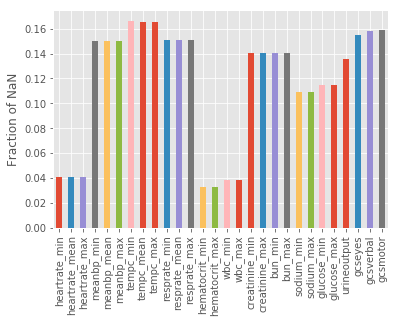

In [44]:
(aps_ad[features[:-1]].isnull().sum()/len(aps_ad)).plot('bar')
plt.ylabel('Fraction of NaN')
plt.savefig('nan_fraction.pdf')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2384b208>,
      dtype=object)

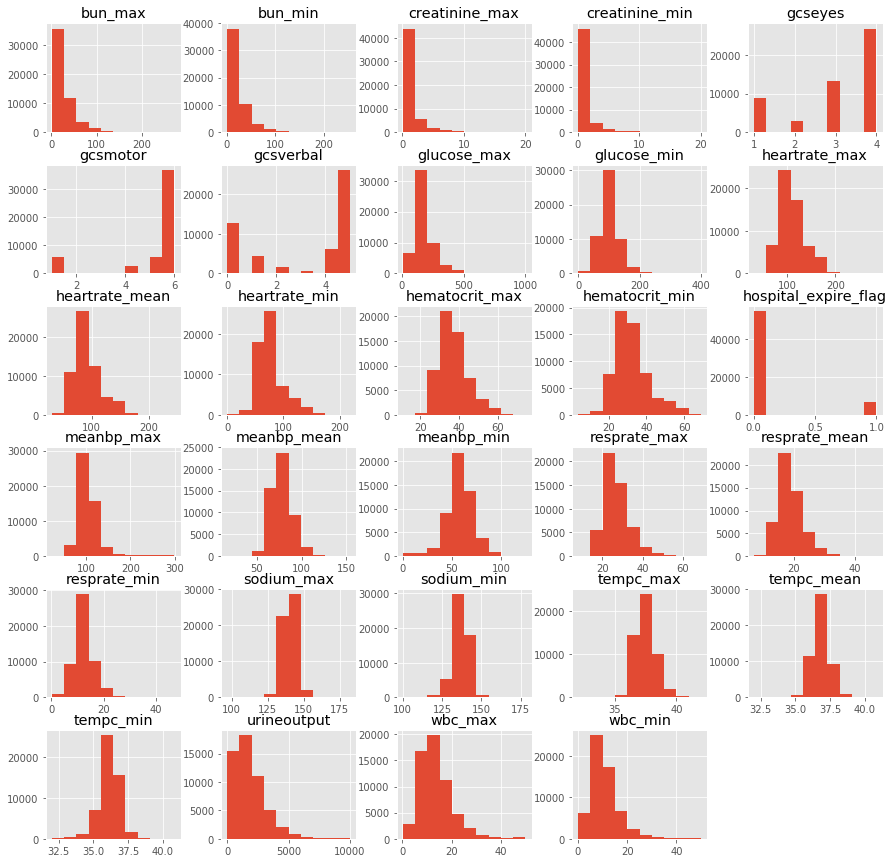

In [19]:
aps_ad.hist(figsize=(15,15))

Below we select 28 features and perform train/test split using stratified sampling

In [20]:
num_features = ['heartrate_min', 'heartrate_mean', 'heartrate_max',\
            'meanbp_min', 'meanbp_mean', 'meanbp_max',\
            'tempc_min', 'tempc_mean', 'tempc_max',\
            'resprate_min', 'resprate_mean', 'resprate_max',\
            'hematocrit_min', 'hematocrit_max', 'wbc_min', 'wbc_max',\
            'creatinine_min', 'creatinine_max', 'bun_min', 'bun_max',\
            'sodium_min', 'sodium_max', 'glucose_min', 'glucose_max', 'urineoutput',\
            'gcseyes', 'gcsverbal', 'gcsmotor']
X = aps_ad[num_features]
y = aps_ad.hospital_expire_flag
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)


In [21]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (49225, 28)
Shape of test set: (12307, 28)
Number of positives in training set: 5287
Number of positives in test set: 1322


We impute all missing values with the median and use MinMaxScaler to scale data to 0-1 range

In [22]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

## Model Implementation: Logistic Regression and Neural Networks

We begin with the logistic regression. In order to fight class imbalance, we scale weights of the classes according to their frequencies of occurance. We use AUROC, F1 score, precision and recall as our metrics.

In [23]:
lr = LogisticRegression(random_state=rnd_state,solver='lbfgs',max_iter=1000,class_weight='balanced',C=1.0,tol=0.0001)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
# Compute metrics
F1 = f1_score(y_test, predictions)
auroc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.40 auroc: 0.84 precision: 0.28 recall: 0.74


Here we use PyTorch to build neural networks

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [29]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 200
# percentage of training set to use as validation
valid_size = 0.2

In [30]:
from torch.utils import data
class Dataset(data.Dataset):
  '''
  A helper class to use in DataLoader
  '''
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'

        X = self.X[index]
        y = self.y[index]

        return X, y

We use DataLoader to split data into train, validation and test sets

In [31]:
train_idx, valid_idx= train_test_split(np.arange(len(y_train.values)),test_size=0.2,shuffle=True,stratify=y_train.values)
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(Dataset(X_test,y_test.values), batch_size=batch_size, 
    num_workers=num_workers)

Below we implement various architectures for our neural network model

In [94]:
class ThreeLayersNet(nn.Module):
    def __init__(self,hidden):
        super(ThreeLayersNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(28, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.hidden)
        self.fc3 = nn.Linear(self.hidden, self.hidden)
        self.fc4 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x

class TwoLayersNet(nn.Module):
    def __init__(self,hidden):
        super(TwoLayersNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(28, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.hidden)
        self.fc3 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
    

class TwoLayersFunnelNet(nn.Module):
    def __init__(self,hidden):
        super(TwoLayersFunnelNet, self).__init__()
        self.hidden = int(hidden/3)
        self.fc1 = nn.Linear(28, self.hidden*2)
        self.fc2 = nn.Linear(self.hidden*2, self.hidden)
        self.fc3 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

class OneLayerNet(nn.Module):
    def __init__(self,hidden=6):
        super(OneLayerNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(28, self.hidden)
        self.fc2 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [33]:
def train_per_hidden(n_epochs, hidden,Net):
    '''
    Trains a net with specified number of epochs and number of units in hidden layer
    
    :param n_epochs: an integer number of epochs
    :param hidden: an integer number of units in the hidden layer
    :param Net: a class of the neural networks
    :return: a tuple containing convergence data and the best model
    '''
    # initialize the NN
    model = Net(hidden=hidden)
    criterion = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_model = None
    valid_loss_min = np.Inf # set initial "min" to infinity
    conv ={'train':[],'valid':[]}
    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        # train the model #
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            target = target.view(-1,1)
            weight=compute_sample_weight(class_weight='balanced', y=target)
            weight=torch.Tensor(weight)
            weight=weight.view(-1,1)
            criterion.weight = weight
            loss = criterion(output.float(), target.float())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()#*data.size(0)

        # validate the model #
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            target = target.view(-1,1)
            weight=compute_sample_weight(class_weight='balanced', y=target)
            weight=torch.Tensor(weight)
            weight=weight.view(-1,1)
            criterion.weight = weight
            loss = criterion(output.float(), target.float())
            # update running validation loss 
            valid_loss += loss.item()#*data.size(0)

        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))
        conv['train'].append(train_loss)
        conv['valid'].append(valid_loss)
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            best_model = model
    return conv, best_model

Below we train neural networks with single hidden layer and varied number of units

In [98]:
# number of epochs to train the model
n_epochs = 200
hidden = [6, 12, 24, 48, 96, 124]
res = {'conv':[],'model':[]}
for h in hidden:
    print('Hidden=',h)
    conv,model = train_per_hidden(n_epochs, h,OneLayerNet)   
    res['conv'].append(conv)
    res['model'].append(model)


Hidden= 6
Epoch: 1 	Training Loss: 0.669252 	Validation Loss: 0.629621
Epoch: 2 	Training Loss: 0.601340 	Validation Loss: 0.577419
Epoch: 3 	Training Loss: 0.569499 	Validation Loss: 0.553277
Epoch: 4 	Training Loss: 0.556091 	Validation Loss: 0.540937
Epoch: 5 	Training Loss: 0.546902 	Validation Loss: 0.537719
Epoch: 6 	Training Loss: 0.542070 	Validation Loss: 0.527677
Epoch: 7 	Training Loss: 0.535657 	Validation Loss: 0.524174
Epoch: 8 	Training Loss: 0.532521 	Validation Loss: 0.522763
Epoch: 9 	Training Loss: 0.527689 	Validation Loss: 0.525351
Epoch: 10 	Training Loss: 0.527722 	Validation Loss: 0.523118
Epoch: 11 	Training Loss: 0.524539 	Validation Loss: 0.518150
Epoch: 12 	Training Loss: 0.523865 	Validation Loss: 0.520173
Epoch: 13 	Training Loss: 0.523653 	Validation Loss: 0.516732
Epoch: 14 	Training Loss: 0.518997 	Validation Loss: 0.517210
Epoch: 15 	Training Loss: 0.517175 	Validation Loss: 0.513042
Epoch: 16 	Training Loss: 0.515906 	Validation Loss: 0.513454
Epoch: 

Epoch: 133 	Training Loss: 0.493025 	Validation Loss: 0.477295
Epoch: 134 	Training Loss: 0.496346 	Validation Loss: 0.484841
Epoch: 135 	Training Loss: 0.496625 	Validation Loss: 0.481937
Epoch: 136 	Training Loss: 0.495836 	Validation Loss: 0.483360
Epoch: 137 	Training Loss: 0.498014 	Validation Loss: 0.485825
Epoch: 138 	Training Loss: 0.496948 	Validation Loss: 0.483222
Epoch: 139 	Training Loss: 0.497332 	Validation Loss: 0.486461
Epoch: 140 	Training Loss: 0.498973 	Validation Loss: 0.486013
Epoch: 141 	Training Loss: 0.493940 	Validation Loss: 0.480753
Epoch: 142 	Training Loss: 0.495466 	Validation Loss: 0.480511
Epoch: 143 	Training Loss: 0.495795 	Validation Loss: 0.480940
Epoch: 144 	Training Loss: 0.495404 	Validation Loss: 0.483230
Epoch: 145 	Training Loss: 0.496977 	Validation Loss: 0.485780
Epoch: 146 	Training Loss: 0.495496 	Validation Loss: 0.486637
Epoch: 147 	Training Loss: 0.492532 	Validation Loss: 0.482396
Epoch: 148 	Training Loss: 0.493970 	Validation Loss: 0

Epoch: 65 	Training Loss: 0.486912 	Validation Loss: 0.483433
Epoch: 66 	Training Loss: 0.488701 	Validation Loss: 0.484526
Epoch: 67 	Training Loss: 0.489072 	Validation Loss: 0.480036
Epoch: 68 	Training Loss: 0.483717 	Validation Loss: 0.477910
Epoch: 69 	Training Loss: 0.484965 	Validation Loss: 0.481900
Epoch: 70 	Training Loss: 0.483622 	Validation Loss: 0.480796
Epoch: 71 	Training Loss: 0.484375 	Validation Loss: 0.476043
Epoch: 72 	Training Loss: 0.489075 	Validation Loss: 0.476148
Epoch: 73 	Training Loss: 0.485328 	Validation Loss: 0.483557
Epoch: 74 	Training Loss: 0.482376 	Validation Loss: 0.482839
Epoch: 75 	Training Loss: 0.484430 	Validation Loss: 0.479357
Epoch: 76 	Training Loss: 0.486681 	Validation Loss: 0.479197
Epoch: 77 	Training Loss: 0.485259 	Validation Loss: 0.477922
Epoch: 78 	Training Loss: 0.486644 	Validation Loss: 0.480707
Epoch: 79 	Training Loss: 0.485079 	Validation Loss: 0.476500
Epoch: 80 	Training Loss: 0.482988 	Validation Loss: 0.473751
Epoch: 8

Epoch: 196 	Training Loss: 0.474034 	Validation Loss: 0.478178
Epoch: 197 	Training Loss: 0.475109 	Validation Loss: 0.472419
Epoch: 198 	Training Loss: 0.472607 	Validation Loss: 0.471756
Epoch: 199 	Training Loss: 0.473341 	Validation Loss: 0.466663
Epoch: 200 	Training Loss: 0.474055 	Validation Loss: 0.471136
Hidden= 24
Epoch: 1 	Training Loss: 0.634530 	Validation Loss: 0.573928
Epoch: 2 	Training Loss: 0.552338 	Validation Loss: 0.536823
Epoch: 3 	Training Loss: 0.529815 	Validation Loss: 0.527713
Epoch: 4 	Training Loss: 0.524597 	Validation Loss: 0.518507
Epoch: 5 	Training Loss: 0.520564 	Validation Loss: 0.520886
Epoch: 6 	Training Loss: 0.516493 	Validation Loss: 0.514567
Epoch: 7 	Training Loss: 0.514360 	Validation Loss: 0.515845
Epoch: 8 	Training Loss: 0.510266 	Validation Loss: 0.517427
Epoch: 9 	Training Loss: 0.508567 	Validation Loss: 0.505960
Epoch: 10 	Training Loss: 0.507475 	Validation Loss: 0.510441
Epoch: 11 	Training Loss: 0.504027 	Validation Loss: 0.500953
E

Epoch: 128 	Training Loss: 0.456112 	Validation Loss: 0.468108
Epoch: 129 	Training Loss: 0.454849 	Validation Loss: 0.460621
Epoch: 130 	Training Loss: 0.452641 	Validation Loss: 0.456585
Epoch: 131 	Training Loss: 0.453539 	Validation Loss: 0.459478
Epoch: 132 	Training Loss: 0.456063 	Validation Loss: 0.459298
Epoch: 133 	Training Loss: 0.452911 	Validation Loss: 0.456389
Epoch: 134 	Training Loss: 0.454580 	Validation Loss: 0.456564
Epoch: 135 	Training Loss: 0.455536 	Validation Loss: 0.456439
Epoch: 136 	Training Loss: 0.455602 	Validation Loss: 0.454688
Epoch: 137 	Training Loss: 0.454625 	Validation Loss: 0.459109
Epoch: 138 	Training Loss: 0.454520 	Validation Loss: 0.456701
Epoch: 139 	Training Loss: 0.454633 	Validation Loss: 0.457874
Epoch: 140 	Training Loss: 0.453368 	Validation Loss: 0.453775
Epoch: 141 	Training Loss: 0.456388 	Validation Loss: 0.458755
Epoch: 142 	Training Loss: 0.452459 	Validation Loss: 0.457896
Epoch: 143 	Training Loss: 0.454458 	Validation Loss: 0

Epoch: 59 	Training Loss: 0.452673 	Validation Loss: 0.457123
Epoch: 60 	Training Loss: 0.452670 	Validation Loss: 0.457675
Epoch: 61 	Training Loss: 0.452311 	Validation Loss: 0.457022
Epoch: 62 	Training Loss: 0.455269 	Validation Loss: 0.456984
Epoch: 63 	Training Loss: 0.452910 	Validation Loss: 0.457610
Epoch: 64 	Training Loss: 0.454784 	Validation Loss: 0.453765
Epoch: 65 	Training Loss: 0.454554 	Validation Loss: 0.454171
Epoch: 66 	Training Loss: 0.454304 	Validation Loss: 0.460842
Epoch: 67 	Training Loss: 0.451685 	Validation Loss: 0.458927
Epoch: 68 	Training Loss: 0.451900 	Validation Loss: 0.459199
Epoch: 69 	Training Loss: 0.453783 	Validation Loss: 0.455636
Epoch: 70 	Training Loss: 0.450724 	Validation Loss: 0.461088
Epoch: 71 	Training Loss: 0.452154 	Validation Loss: 0.451980
Epoch: 72 	Training Loss: 0.452898 	Validation Loss: 0.452511
Epoch: 73 	Training Loss: 0.451001 	Validation Loss: 0.455559
Epoch: 74 	Training Loss: 0.449973 	Validation Loss: 0.460865
Epoch: 7

Epoch: 190 	Training Loss: 0.438645 	Validation Loss: 0.448574
Epoch: 191 	Training Loss: 0.438850 	Validation Loss: 0.450792
Epoch: 192 	Training Loss: 0.440295 	Validation Loss: 0.452541
Epoch: 193 	Training Loss: 0.437103 	Validation Loss: 0.447074
Epoch: 194 	Training Loss: 0.435422 	Validation Loss: 0.447594
Epoch: 195 	Training Loss: 0.438082 	Validation Loss: 0.447379
Epoch: 196 	Training Loss: 0.438333 	Validation Loss: 0.451227
Epoch: 197 	Training Loss: 0.437982 	Validation Loss: 0.447875
Epoch: 198 	Training Loss: 0.436825 	Validation Loss: 0.451977
Epoch: 199 	Training Loss: 0.440104 	Validation Loss: 0.454868
Epoch: 200 	Training Loss: 0.437056 	Validation Loss: 0.450208
Hidden= 96
Epoch: 1 	Training Loss: 0.589702 	Validation Loss: 0.535350
Epoch: 2 	Training Loss: 0.523910 	Validation Loss: 0.518975
Epoch: 3 	Training Loss: 0.513210 	Validation Loss: 0.515697
Epoch: 4 	Training Loss: 0.507640 	Validation Loss: 0.510207
Epoch: 5 	Training Loss: 0.505382 	Validation Loss: 

Epoch: 122 	Training Loss: 0.428305 	Validation Loss: 0.448238
Epoch: 123 	Training Loss: 0.429591 	Validation Loss: 0.443285
Epoch: 124 	Training Loss: 0.430437 	Validation Loss: 0.454311
Epoch: 125 	Training Loss: 0.430544 	Validation Loss: 0.451375
Epoch: 126 	Training Loss: 0.428432 	Validation Loss: 0.448722
Epoch: 127 	Training Loss: 0.427870 	Validation Loss: 0.444404
Epoch: 128 	Training Loss: 0.429183 	Validation Loss: 0.447293
Epoch: 129 	Training Loss: 0.429316 	Validation Loss: 0.446167
Epoch: 130 	Training Loss: 0.427990 	Validation Loss: 0.450282
Epoch: 131 	Training Loss: 0.430572 	Validation Loss: 0.454815
Epoch: 132 	Training Loss: 0.427134 	Validation Loss: 0.455360
Epoch: 133 	Training Loss: 0.427935 	Validation Loss: 0.450190
Epoch: 134 	Training Loss: 0.427383 	Validation Loss: 0.449292
Epoch: 135 	Training Loss: 0.428948 	Validation Loss: 0.447787
Epoch: 136 	Training Loss: 0.428288 	Validation Loss: 0.449754
Epoch: 137 	Training Loss: 0.428626 	Validation Loss: 0

Epoch: 53 	Training Loss: 0.440169 	Validation Loss: 0.455936
Epoch: 54 	Training Loss: 0.441253 	Validation Loss: 0.455135
Epoch: 55 	Training Loss: 0.441253 	Validation Loss: 0.450516
Epoch: 56 	Training Loss: 0.442461 	Validation Loss: 0.452515
Epoch: 57 	Training Loss: 0.439797 	Validation Loss: 0.449342
Epoch: 58 	Training Loss: 0.438607 	Validation Loss: 0.449817
Epoch: 59 	Training Loss: 0.441104 	Validation Loss: 0.449721
Epoch: 60 	Training Loss: 0.439821 	Validation Loss: 0.450471
Epoch: 61 	Training Loss: 0.438134 	Validation Loss: 0.454104
Epoch: 62 	Training Loss: 0.439752 	Validation Loss: 0.452718
Epoch: 63 	Training Loss: 0.438176 	Validation Loss: 0.448871
Epoch: 64 	Training Loss: 0.439327 	Validation Loss: 0.443692
Epoch: 65 	Training Loss: 0.437727 	Validation Loss: 0.452133
Epoch: 66 	Training Loss: 0.439154 	Validation Loss: 0.449401
Epoch: 67 	Training Loss: 0.438418 	Validation Loss: 0.446970
Epoch: 68 	Training Loss: 0.437344 	Validation Loss: 0.449468
Epoch: 6

Epoch: 184 	Training Loss: 0.417695 	Validation Loss: 0.444504
Epoch: 185 	Training Loss: 0.416671 	Validation Loss: 0.447899
Epoch: 186 	Training Loss: 0.417773 	Validation Loss: 0.444432
Epoch: 187 	Training Loss: 0.419771 	Validation Loss: 0.445955
Epoch: 188 	Training Loss: 0.416045 	Validation Loss: 0.447991
Epoch: 189 	Training Loss: 0.417526 	Validation Loss: 0.448543
Epoch: 190 	Training Loss: 0.417606 	Validation Loss: 0.443479
Epoch: 191 	Training Loss: 0.419088 	Validation Loss: 0.450300
Epoch: 192 	Training Loss: 0.418899 	Validation Loss: 0.447008
Epoch: 193 	Training Loss: 0.418049 	Validation Loss: 0.447053
Epoch: 194 	Training Loss: 0.415139 	Validation Loss: 0.446834
Epoch: 195 	Training Loss: 0.416296 	Validation Loss: 0.447938
Epoch: 196 	Training Loss: 0.414996 	Validation Loss: 0.445460
Epoch: 197 	Training Loss: 0.418612 	Validation Loss: 0.449095
Epoch: 198 	Training Loss: 0.416938 	Validation Loss: 0.447237
Epoch: 199 	Training Loss: 0.419088 	Validation Loss: 0

Plot loss for against epochs during training of model with varied number of units in the hidden layer 

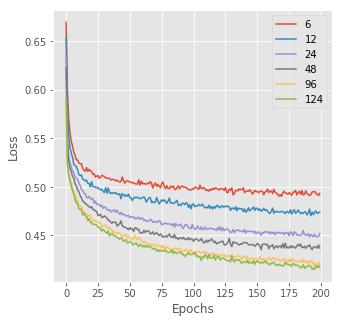

In [99]:
f, axs = plt.subplots(1,1,figsize=(5,5))

for h,conv in zip(hidden,res['conv']):
    plt.plot(conv['train'],label=h)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.savefig('hidden_aps.pdf')

In [100]:
def get_predictions(model):
    '''
    Compute predictions on a test set using a given model
    
    :param model: neural network model to be tested
    :return: a list of predictions
    '''
    criterion = nn.BCELoss(reduction='mean')
    test_loss = 0.0
    predictions = []
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        target = target.view(-1,1)
        weight=compute_sample_weight(class_weight='balanced', y=target)
        weight=torch.Tensor(weight)
        weight=weight.view(-1,1)
        criterion.weight = weight
        loss = criterion(output.float(), target.float())
        # update test loss 
        test_loss += loss.item()#*data.size(0)
        predictions += output.view(1,-1).tolist()[0]
    return predictions

Below we compute metrics for the all models obtained in a previous step. For visual purposes we construct a dataframe and plot convergence of the metrics below.

In [104]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in res['model']:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.438 auroc: 0.861 precision: 0.306 recall: 0.766
TEST SET f1: 0.429 auroc: 0.868 precision: 0.292 recall: 0.809
TEST SET f1: 0.452 auroc: 0.875 precision: 0.318 recall: 0.783
TEST SET f1: 0.458 auroc: 0.877 precision: 0.323 recall: 0.788
TEST SET f1: 0.471 auroc: 0.882 precision: 0.338 recall: 0.777
TEST SET f1: 0.445 auroc: 0.882 precision: 0.305 recall: 0.818


In [105]:
metrics['hidden'] = hidden
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index('hidden')
df_metrics.round(3)

,F1,AUROC,Precision,Recall
hidden,,,,
6,0.438,0.861,0.306,0.766
12,0.429,0.868,0.292,0.809
24,0.452,0.875,0.318,0.783
48,0.458,0.877,0.323,0.788
96,0.471,0.882,0.338,0.777
124,0.445,0.882,0.305,0.818


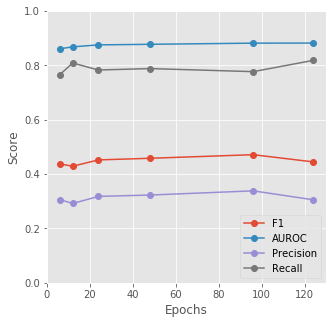

In [106]:
f, axs = plt.subplots(1,1,figsize=(5,5))

for column in df_metrics.columns:
    plt.plot(df_metrics.index,df_metrics[column],'-o',label=column)
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Epochs')

plt.savefig('scores_per_hidden_aps.pdf')

In the next several cells we construct neural networks of various architectures: one layer with 96 units (96), two layers with 48 units each (48,48), two layers with 64 and 32 units (64,32), two layers with 96 units each (96,96), three layers with 32 units each (32,32,32).

In [110]:
# number of epochs to train the model
n_epochs = 200
hidden = 96
conv,one_layer_model = train_per_hidden(n_epochs, hidden, OneLayerNet)   

Epoch: 1 	Training Loss: 0.605276 	Validation Loss: 0.545670
Epoch: 2 	Training Loss: 0.529054 	Validation Loss: 0.521827
Epoch: 3 	Training Loss: 0.512133 	Validation Loss: 0.512336
Epoch: 4 	Training Loss: 0.506877 	Validation Loss: 0.509459
Epoch: 5 	Training Loss: 0.503790 	Validation Loss: 0.505809
Epoch: 6 	Training Loss: 0.499486 	Validation Loss: 0.502577
Epoch: 7 	Training Loss: 0.496826 	Validation Loss: 0.500575
Epoch: 8 	Training Loss: 0.492386 	Validation Loss: 0.494914
Epoch: 9 	Training Loss: 0.489343 	Validation Loss: 0.493749
Epoch: 10 	Training Loss: 0.489636 	Validation Loss: 0.494441
Epoch: 11 	Training Loss: 0.486542 	Validation Loss: 0.488289
Epoch: 12 	Training Loss: 0.483008 	Validation Loss: 0.483564
Epoch: 13 	Training Loss: 0.481283 	Validation Loss: 0.483146
Epoch: 14 	Training Loss: 0.479350 	Validation Loss: 0.481974
Epoch: 15 	Training Loss: 0.477778 	Validation Loss: 0.482411
Epoch: 16 	Training Loss: 0.477105 	Validation Loss: 0.478035
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.432065 	Validation Loss: 0.448400
Epoch: 134 	Training Loss: 0.429383 	Validation Loss: 0.446608
Epoch: 135 	Training Loss: 0.428103 	Validation Loss: 0.447422
Epoch: 136 	Training Loss: 0.432956 	Validation Loss: 0.448989
Epoch: 137 	Training Loss: 0.431504 	Validation Loss: 0.448645
Epoch: 138 	Training Loss: 0.428642 	Validation Loss: 0.450112
Epoch: 139 	Training Loss: 0.429121 	Validation Loss: 0.448334
Epoch: 140 	Training Loss: 0.430530 	Validation Loss: 0.450345
Epoch: 141 	Training Loss: 0.430171 	Validation Loss: 0.448945
Epoch: 142 	Training Loss: 0.429854 	Validation Loss: 0.452292
Epoch: 143 	Training Loss: 0.427441 	Validation Loss: 0.446616
Epoch: 144 	Training Loss: 0.430104 	Validation Loss: 0.449504
Epoch: 145 	Training Loss: 0.427845 	Validation Loss: 0.450041
Epoch: 146 	Training Loss: 0.431557 	Validation Loss: 0.458149
Epoch: 147 	Training Loss: 0.431947 	Validation Loss: 0.453556
Epoch: 148 	Training Loss: 0.426622 	Validation Loss: 0

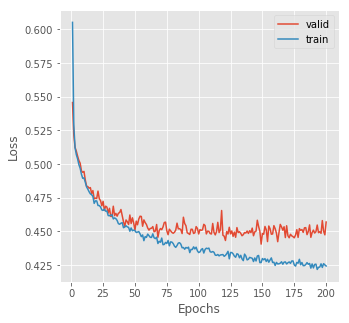

In [111]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_one_layer.pdf')

In [112]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [one_layer_model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.490 auroc: 0.883 precision: 0.365 recall: 0.747


In [113]:
# number of epochs to train the model
n_epochs = 200
hidden = 48
conv,two_layers_model = train_per_hidden(n_epochs, hidden, TwoLayersNet)   

Epoch: 1 	Training Loss: 0.590789 	Validation Loss: 0.529452
Epoch: 2 	Training Loss: 0.523227 	Validation Loss: 0.513972
Epoch: 3 	Training Loss: 0.509450 	Validation Loss: 0.509366
Epoch: 4 	Training Loss: 0.503135 	Validation Loss: 0.500838
Epoch: 5 	Training Loss: 0.498747 	Validation Loss: 0.494034
Epoch: 6 	Training Loss: 0.493131 	Validation Loss: 0.493180
Epoch: 7 	Training Loss: 0.490437 	Validation Loss: 0.489502
Epoch: 8 	Training Loss: 0.487388 	Validation Loss: 0.482747
Epoch: 9 	Training Loss: 0.486716 	Validation Loss: 0.484075
Epoch: 10 	Training Loss: 0.482766 	Validation Loss: 0.482540
Epoch: 11 	Training Loss: 0.480537 	Validation Loss: 0.473146
Epoch: 12 	Training Loss: 0.477617 	Validation Loss: 0.482441
Epoch: 13 	Training Loss: 0.477226 	Validation Loss: 0.481481
Epoch: 14 	Training Loss: 0.475391 	Validation Loss: 0.472636
Epoch: 15 	Training Loss: 0.471431 	Validation Loss: 0.475566
Epoch: 16 	Training Loss: 0.468965 	Validation Loss: 0.476031
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.427399 	Validation Loss: 0.455766
Epoch: 134 	Training Loss: 0.429344 	Validation Loss: 0.452423
Epoch: 135 	Training Loss: 0.429992 	Validation Loss: 0.456754
Epoch: 136 	Training Loss: 0.430019 	Validation Loss: 0.450554
Epoch: 137 	Training Loss: 0.428806 	Validation Loss: 0.455308
Epoch: 138 	Training Loss: 0.429342 	Validation Loss: 0.451489
Epoch: 139 	Training Loss: 0.426597 	Validation Loss: 0.453352
Epoch: 140 	Training Loss: 0.429115 	Validation Loss: 0.461793
Epoch: 141 	Training Loss: 0.429355 	Validation Loss: 0.455843
Epoch: 142 	Training Loss: 0.430724 	Validation Loss: 0.462854
Epoch: 143 	Training Loss: 0.429239 	Validation Loss: 0.450014
Epoch: 144 	Training Loss: 0.429802 	Validation Loss: 0.459628
Epoch: 145 	Training Loss: 0.426030 	Validation Loss: 0.453094
Epoch: 146 	Training Loss: 0.427994 	Validation Loss: 0.452089
Epoch: 147 	Training Loss: 0.430821 	Validation Loss: 0.457672
Epoch: 148 	Training Loss: 0.429011 	Validation Loss: 0

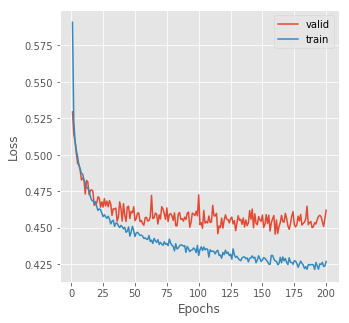

In [114]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_two_layers.pdf')

In [115]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [two_layers_model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.441 auroc: 0.878 precision: 0.300 recall: 0.826


In [116]:
# number of epochs to train the model
n_epochs = 200
hidden = 96
conv,two_layers_model = train_per_hidden(n_epochs, hidden, TwoLayersNet)   

Epoch: 1 	Training Loss: 0.569318 	Validation Loss: 0.518338
Epoch: 2 	Training Loss: 0.515182 	Validation Loss: 0.503323
Epoch: 3 	Training Loss: 0.501394 	Validation Loss: 0.495594
Epoch: 4 	Training Loss: 0.491300 	Validation Loss: 0.487104
Epoch: 5 	Training Loss: 0.483059 	Validation Loss: 0.485362
Epoch: 6 	Training Loss: 0.475439 	Validation Loss: 0.472589
Epoch: 7 	Training Loss: 0.474516 	Validation Loss: 0.468993
Epoch: 8 	Training Loss: 0.469667 	Validation Loss: 0.471898
Epoch: 9 	Training Loss: 0.466103 	Validation Loss: 0.471685
Epoch: 10 	Training Loss: 0.464640 	Validation Loss: 0.482340
Epoch: 11 	Training Loss: 0.461429 	Validation Loss: 0.460875
Epoch: 12 	Training Loss: 0.461115 	Validation Loss: 0.460222
Epoch: 13 	Training Loss: 0.458551 	Validation Loss: 0.460852
Epoch: 14 	Training Loss: 0.457228 	Validation Loss: 0.465035
Epoch: 15 	Training Loss: 0.456108 	Validation Loss: 0.466315
Epoch: 16 	Training Loss: 0.457549 	Validation Loss: 0.465824
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.406228 	Validation Loss: 0.451335
Epoch: 134 	Training Loss: 0.408227 	Validation Loss: 0.455432
Epoch: 135 	Training Loss: 0.404838 	Validation Loss: 0.451617
Epoch: 136 	Training Loss: 0.404717 	Validation Loss: 0.455702
Epoch: 137 	Training Loss: 0.403774 	Validation Loss: 0.451593
Epoch: 138 	Training Loss: 0.405793 	Validation Loss: 0.457322
Epoch: 139 	Training Loss: 0.406194 	Validation Loss: 0.453401
Epoch: 140 	Training Loss: 0.408001 	Validation Loss: 0.472064
Epoch: 141 	Training Loss: 0.406926 	Validation Loss: 0.460689
Epoch: 142 	Training Loss: 0.404175 	Validation Loss: 0.457721
Epoch: 143 	Training Loss: 0.403137 	Validation Loss: 0.446403
Epoch: 144 	Training Loss: 0.405503 	Validation Loss: 0.453411
Epoch: 145 	Training Loss: 0.403862 	Validation Loss: 0.459161
Epoch: 146 	Training Loss: 0.403193 	Validation Loss: 0.480989
Epoch: 147 	Training Loss: 0.404654 	Validation Loss: 0.452984
Epoch: 148 	Training Loss: 0.403830 	Validation Loss: 0

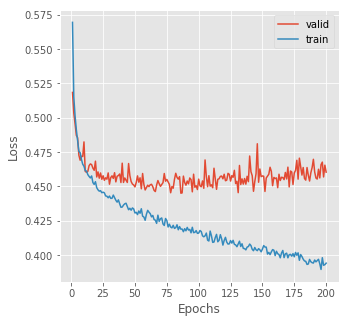

In [117]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_two_layers_2.pdf')

In [118]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [two_layers_model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.447 auroc: 0.878 precision: 0.309 recall: 0.811


In [120]:
# number of epochs to train the model
n_epochs = 200
hidden = 96
conv,funnel_model = train_per_hidden(n_epochs, hidden, TwoLayersFunnelNet)   

Epoch: 1 	Training Loss: 0.597864 	Validation Loss: 0.524708
Epoch: 2 	Training Loss: 0.520929 	Validation Loss: 0.516403
Epoch: 3 	Training Loss: 0.509597 	Validation Loss: 0.518591
Epoch: 4 	Training Loss: 0.500139 	Validation Loss: 0.500909
Epoch: 5 	Training Loss: 0.494497 	Validation Loss: 0.496393
Epoch: 6 	Training Loss: 0.492772 	Validation Loss: 0.485271
Epoch: 7 	Training Loss: 0.487204 	Validation Loss: 0.488171
Epoch: 8 	Training Loss: 0.484100 	Validation Loss: 0.489716
Epoch: 9 	Training Loss: 0.477070 	Validation Loss: 0.483106
Epoch: 10 	Training Loss: 0.474095 	Validation Loss: 0.472571
Epoch: 11 	Training Loss: 0.475836 	Validation Loss: 0.480431
Epoch: 12 	Training Loss: 0.469608 	Validation Loss: 0.474070
Epoch: 13 	Training Loss: 0.468515 	Validation Loss: 0.471203
Epoch: 14 	Training Loss: 0.467385 	Validation Loss: 0.470959
Epoch: 15 	Training Loss: 0.464820 	Validation Loss: 0.466614
Epoch: 16 	Training Loss: 0.463694 	Validation Loss: 0.470364
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.428204 	Validation Loss: 0.449645
Epoch: 134 	Training Loss: 0.425163 	Validation Loss: 0.455644
Epoch: 135 	Training Loss: 0.426257 	Validation Loss: 0.451363
Epoch: 136 	Training Loss: 0.425924 	Validation Loss: 0.453104
Epoch: 137 	Training Loss: 0.421741 	Validation Loss: 0.457668
Epoch: 138 	Training Loss: 0.422614 	Validation Loss: 0.450922
Epoch: 139 	Training Loss: 0.424832 	Validation Loss: 0.451002
Epoch: 140 	Training Loss: 0.423565 	Validation Loss: 0.461058
Epoch: 141 	Training Loss: 0.425283 	Validation Loss: 0.452906
Epoch: 142 	Training Loss: 0.426340 	Validation Loss: 0.456172
Epoch: 143 	Training Loss: 0.425381 	Validation Loss: 0.458402
Epoch: 144 	Training Loss: 0.419457 	Validation Loss: 0.460598
Epoch: 145 	Training Loss: 0.424694 	Validation Loss: 0.455072
Epoch: 146 	Training Loss: 0.424507 	Validation Loss: 0.453743
Epoch: 147 	Training Loss: 0.421754 	Validation Loss: 0.451382
Epoch: 148 	Training Loss: 0.421217 	Validation Loss: 0

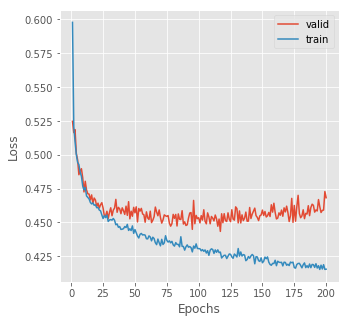

In [121]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_two_layers_funnel.pdf')

In [122]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [funnel_model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.447 auroc: 0.879 precision: 0.309 recall: 0.810


In [123]:
# number of epochs to train the model
n_epochs = 300
hidden = 32
conv,three_layers_model = train_per_hidden(n_epochs, hidden, ThreeLayersNet)   

Epoch: 1 	Training Loss: 0.623517 	Validation Loss: 0.547823
Epoch: 2 	Training Loss: 0.539043 	Validation Loss: 0.520276
Epoch: 3 	Training Loss: 0.521827 	Validation Loss: 0.504993
Epoch: 4 	Training Loss: 0.514297 	Validation Loss: 0.502395
Epoch: 5 	Training Loss: 0.503381 	Validation Loss: 0.498276
Epoch: 6 	Training Loss: 0.497767 	Validation Loss: 0.493883
Epoch: 7 	Training Loss: 0.497241 	Validation Loss: 0.485741
Epoch: 8 	Training Loss: 0.493060 	Validation Loss: 0.485236
Epoch: 9 	Training Loss: 0.493019 	Validation Loss: 0.498878
Epoch: 10 	Training Loss: 0.491983 	Validation Loss: 0.489355
Epoch: 11 	Training Loss: 0.486389 	Validation Loss: 0.481081
Epoch: 12 	Training Loss: 0.485486 	Validation Loss: 0.476833
Epoch: 13 	Training Loss: 0.486462 	Validation Loss: 0.481049
Epoch: 14 	Training Loss: 0.481051 	Validation Loss: 0.474676
Epoch: 15 	Training Loss: 0.480176 	Validation Loss: 0.472334
Epoch: 16 	Training Loss: 0.478692 	Validation Loss: 0.477216
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.440129 	Validation Loss: 0.452841
Epoch: 134 	Training Loss: 0.444985 	Validation Loss: 0.458633
Epoch: 135 	Training Loss: 0.444048 	Validation Loss: 0.455545
Epoch: 136 	Training Loss: 0.442988 	Validation Loss: 0.450198
Epoch: 137 	Training Loss: 0.441994 	Validation Loss: 0.458883
Epoch: 138 	Training Loss: 0.443933 	Validation Loss: 0.453481
Epoch: 139 	Training Loss: 0.443657 	Validation Loss: 0.456988
Epoch: 140 	Training Loss: 0.445220 	Validation Loss: 0.449359
Epoch: 141 	Training Loss: 0.442133 	Validation Loss: 0.459914
Epoch: 142 	Training Loss: 0.441774 	Validation Loss: 0.460770
Epoch: 143 	Training Loss: 0.440059 	Validation Loss: 0.461566
Epoch: 144 	Training Loss: 0.441416 	Validation Loss: 0.452983
Epoch: 145 	Training Loss: 0.442006 	Validation Loss: 0.454411
Epoch: 146 	Training Loss: 0.439801 	Validation Loss: 0.454846
Epoch: 147 	Training Loss: 0.443296 	Validation Loss: 0.455254
Epoch: 148 	Training Loss: 0.443383 	Validation Loss: 0

Epoch: 264 	Training Loss: 0.437024 	Validation Loss: 0.444687
Epoch: 265 	Training Loss: 0.432729 	Validation Loss: 0.457389
Epoch: 266 	Training Loss: 0.436270 	Validation Loss: 0.451234
Epoch: 267 	Training Loss: 0.431479 	Validation Loss: 0.449900
Epoch: 268 	Training Loss: 0.434838 	Validation Loss: 0.450769
Epoch: 269 	Training Loss: 0.433566 	Validation Loss: 0.450263
Epoch: 270 	Training Loss: 0.432826 	Validation Loss: 0.460834
Epoch: 271 	Training Loss: 0.433674 	Validation Loss: 0.452866
Epoch: 272 	Training Loss: 0.433882 	Validation Loss: 0.455164
Epoch: 273 	Training Loss: 0.431447 	Validation Loss: 0.450708
Epoch: 274 	Training Loss: 0.434907 	Validation Loss: 0.455133
Epoch: 275 	Training Loss: 0.434035 	Validation Loss: 0.472654
Epoch: 276 	Training Loss: 0.436675 	Validation Loss: 0.450766
Epoch: 277 	Training Loss: 0.436020 	Validation Loss: 0.453665
Epoch: 278 	Training Loss: 0.432859 	Validation Loss: 0.456267
Epoch: 279 	Training Loss: 0.434417 	Validation Loss: 0

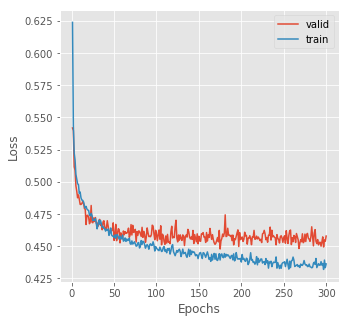

In [84]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_three_layers.pdf')

In [124]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [three_layers_model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.430 auroc: 0.877 precision: 0.292 recall: 0.812


## Results

Our investigations above showed that the best performance is achieved for a neural net with one hidden layer and 96 units. Below we examine its performance against APS and logistic regression.

In [136]:
# merge two dataframes to combine APS score and mortality outcome into the same table
apsiii = aps.merge(ad,how='left',on=['hadm_id','subject_id'])

In [137]:
# metrics calculated using APS model
F1 = f1_score(y_full, aps_predictions.round())
auroc = roc_auc_score(y_full, aps_predictions)
precision = precision_score(y_full, aps_predictions.round())
recall = recall_score(y_full, aps_predictions.round())
res = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.229 auroc: 0.799 precision: 0.651 recall: 0.139


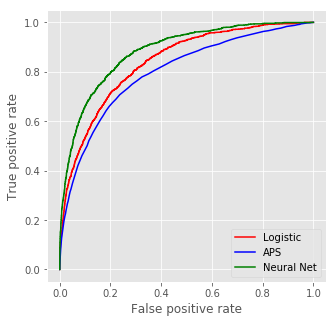

In [138]:
# ROC curves for three models: logistic, neural net and APS
f, axs = plt.subplots(1,1,figsize=(5,5))

x,y,_ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(x,y,label='Logistic',color='red')
x,y,_ = roc_curve(y_full, aps_predictions)
plt.plot(x,y,label='APS',color='blue')
predictions = get_predictions(one_layer_model)
x,y,_ = roc_curve(y_test, predictions)
plt.plot(x,y,label='Neural Net',color='green')

plt.legend(loc='best')
axs.set_xlabel('False positive rate')
axs.set_ylabel('True positive rate')

plt.savefig('logisic_aps_net.pdf')